In [11]:
import numpy as np
import pandas as pd
import os
import requests
import io
from datetime import datetime, timedelta
import multiprocessing
import arviz as az
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
import pymc as pm
import pytensor
pytensor.config.floatX = "float32"
import jax
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from data.fetch_match_data import load_data
#os.environ["JAX_ENABLE_X64"] = "True"  # Enable double precision in JAX
#jax.config.update("jax_enable_x64", True)


In [12]:
def resimulate_matches_with_xg(matches_df, shot_data, n_simulations=25):
    """
    Resimulate matches based on xG data while duplicating real matches
    to maintain a 30:70 ratio between real and simulated matches.
    """
    # Start with a copy of the original matches
    original_matches = matches_df.copy()
    original_matches['is_simulation'] = False
    
    print(f"Resimulating {len(matches_df)} matches ({n_simulations} simulations each)")
    
    # Initialize an empty list to store simulated matches
    simulated_matches = []
    
    # Process each match in the original dataset
    for _, match in matches_df.iterrows():
        match_url = match.get('match_url')
        if pd.isna(match_url):
            continue  # Skip matches without URL identifier
        
        # Get shots for this match
        home_team = match['home_team']
        away_team = match['away_team']
        
        # Filter shots for this specific match
        match_shots = shot_data[shot_data['match_url'] == match_url].copy()
        
        # Skip matches with no shot data
        if len(match_shots) == 0:
            continue
            
        # Separate home and away shots
        home_shots = match_shots[match_shots['Team'] == home_team]
        away_shots = match_shots[match_shots['Team'] == away_team]
        
        # Get xG values for each shot
        home_xg_values = home_shots['xG'].values
        away_xg_values = away_shots['xG'].values
        
        # Create multiple simulations of this match
        for i in range(n_simulations):
            # Create a copy of the match for this simulation
            sim_match = match.copy()
            
            # Simulate each shot as a Bernoulli trial with probability = xG
            home_goals_sim = sum(np.random.random() < xg for xg in home_xg_values)
            away_goals_sim = sum(np.random.random() < xg for xg in away_xg_values)
            
            # Replace actual goals with simulated goals
            sim_match['home_goals'] = home_goals_sim
            sim_match['away_goals'] = away_goals_sim
            
            # Add simulation metadata
            sim_match['is_simulation'] = True
            sim_match['simulation_id'] = i
            
            # Add to simulated matches list
            simulated_matches.append(sim_match)
    
    # Convert list of simulated matches to DataFrame
    if not simulated_matches:
        return original_matches
        
    simulated_df = pd.DataFrame(simulated_matches)
    
    # Calculate how many times to duplicate real matches to achieve 30:70 ratio
    # If simulated is 70%, real is 30%, so ratio of real:simulated is 30:70 = 3:7
    num_simulated = len(simulated_df)
    target_num_real = int(num_simulated * (30/70))
    
    # Number of times to duplicate the original matches
    duplication_factor = max(1, target_num_real // len(original_matches))
    remainder = target_num_real % len(original_matches)
    
    # Duplicate original matches
    duplicated_originals = pd.concat([original_matches] * duplication_factor, ignore_index=True)
    
    # Add remainder if any
    if remainder > 0:
        additional_originals = original_matches.iloc[:remainder].copy()
        duplicated_originals = pd.concat([duplicated_originals, additional_originals], ignore_index=True)
    
    # Combine duplicated original and simulated matches
    expanded_matches = pd.concat([duplicated_originals, simulated_df], ignore_index=True)
    
    print(f"Original matches: {len(original_matches)}")
    print(f"Duplicated to: {len(duplicated_originals)} ({len(duplicated_originals)/len(expanded_matches)*100:.1f}%)")
    print(f"Simulated matches: {len(simulated_df)} ({len(simulated_df)/len(expanded_matches)*100:.1f}%)")
    print(f"Total matches: {len(expanded_matches)}")
    
    return expanded_matches

In [13]:
def build_bayesian_model(home_teams, away_teams, home_goals, away_goals, dates, leagues):
    print("Building Bayesian model...")
    print(f"Dataset size: {len(home_teams)} matches")
    print(f"Time span: {dates.min()} to {dates.max()}")
    
    # get unique teams and leagues
    teams = sorted(list(set(home_teams) | set(away_teams))) # alphabetically sorts and de-dupes list of team names
    unique_leagues = sorted(list(set(leagues)))

    # sets index values for each team/league within a dict
    team_indices = {team: idx for idx, team in enumerate(teams)}
    league_indices = {league: idx for idx, league in enumerate(unique_leagues)}

    # convert date into time differences
    max_date = np.max(dates)
    time_diffs = (max_date - dates).dt.days

    # convert team names to index vals
    home_idx = [team_indices[team] for team in home_teams]
    away_idx = [team_indices[team] for team in away_teams]

    # Get league index for each team directly from the data
    home_league_idx = [league_indices[league] for league in leagues]
    away_league_idx = [league_indices[league] for league in leagues]
    
    # Create array of league indices for each team
    team_league_idx = np.zeros(len(teams), dtype=int)
    for team, idx in team_indices.items():
        # Find first occurrence of this team and use its league
        if team in home_teams:
            first_idx = list(home_teams).index(team)
            team_league_idx[idx] = home_league_idx[first_idx]
        else:
            first_idx = list(away_teams).index(team)
            team_league_idx[idx] = away_league_idx[first_idx]

    with pm.Model() as model:
        # league level parameters for league strengths
        league_attack_mu = pm.Normal("league_attack_mu", mu=0, sigma=0.5) # using a normal distribution to infer average league attack value
        league_attack_sigma = pm.HalfNormal("league_attack_sigma", sigma=0.5) # using a half normal dist to infer league attack spread, half normal as std must be positive
        league_defense_mu = pm.Normal("league_defense_mu", mu=0, sigma=0.5)
        league_defense_sigma = pm.HalfNormal("league_defense_sigma", sigma=0.5)

        # creating raw league strengths for all leagues EXCEPT Premier League
        premier_league_idx = league_indices["Premier League"]
        league_strength_raw = pm.Normal("league_strength_raw", mu=-0.5, sigma=0.3, shape=len(unique_leagues)-1) # setting mu to -0.5 as other leagues are expected to be weaker. shape = -1 as Premier league will be 0
        league_strength = pm.Deterministic( # deterministic variable as derived from other random variables (league strengths)
            "league_strength",
            pm.math.concatenate([
                league_strength_raw[:premier_league_idx],
                pm.math.zeros(1), # creating array that will have all league strengths with Premier league in the "middle" with 0
                league_strength_raw[premier_league_idx:]
            ])
        )

        # team strength initalisation
        attack_raw = pm.Normal("attack_raw", mu=0, sigma=1, shape=len(teams)) # initalising normal distribution for relative attacking strength with mean 0 and std of 1
        defense_raw = pm.Normal('defense_raw', mu=0, sigma=1, shape=len(teams))

        # scale team strengths by league
        attack = pm.Deterministic(
            "attack",
            attack_raw * league_attack_sigma + league_attack_mu + league_strength[team_league_idx] # combining raw team strength with league average/std and then penalising by league overall strength
        )
        defense = pm.Deterministic(
            "defense",
            defense_raw * league_defense_sigma + league_defense_mu + league_strength[team_league_idx]
        )

        # initalise time decay parameter
        #decay_rate = pm.HalfNormal("decay_rate", sigma=1.5/365) # balanced prior for decay rate, divided by 365 to account for daily rate
        decay_rate = np.log(2)/120 # half life of 120 days

        # initalise home advantage
        home_advantage = pm.Normal("home_advantage", mu=0.2, sigma=0.1) # initalises home_adv to 0.2 and has std of 0.1 so val can extend or reduce that much

        # create time decay factor to apply to expected goals
        time_factor = pm.math.exp(-decay_rate * time_diffs)

        #combined_factor = time_factor * weights

        # expected goals parameter for both xG and goals, applied time decay
        home_theta = time_factor * pm.math.exp(attack[home_idx] - defense[away_idx] + home_advantage) # we use exponential so it's always positive and team strengths are multiplicative
        away_theta = time_factor * pm.math.exp(attack[away_idx] - defense[home_idx])

        # goals likelihood (poisson for actual goals)
        home_goals_like = pm.Poisson("home_goals", mu=home_theta, observed=home_goals) 
        away_goals_like = pm.Poisson("away_goals", mu=away_theta, observed=away_goals)

        os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz-12.2.1-win64\bin'
        graph = pm.model_to_graphviz(model)
        display(graph)

    return model, team_indices, league_indices

def sample_model(model, draws=1000, tune=1000, chains=4, cores=None):
    with model:
        # Use sample_numpyro_nuts instead
        trace = pm.sample(
            nuts_sampler='numpyro',
            draws=draws,
            tune=tune,
            chains=chains,
        )
    return trace
    
# Function to monitor memory usage
def print_memory_usage():
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")




def get_league_strengths(trace, league_indices):
    leagues = list(league_indices.keys())
    league_strength_means = trace.posterior['league_strength'].mean(dim=['chain', 'draw']).values
    
    results = pd.DataFrame({
        'league': leagues,
        'league_strength': league_strength_means
    })
    
    return results.round(3).sort_values('league_strength', ascending=False)

def get_hierarchical_team_strengths(trace, team_indices, league_indices, team_leagues, current_teams):
    teams = list(team_indices.keys())
    attack_means = trace.posterior['attack'].mean(dim=['chain', 'draw']).values
    defense_means = trace.posterior['defense'].mean(dim=['chain', 'draw']).values
    home_adv = trace.posterior['home_advantage'].mean(dim=['chain', 'draw']).values
    
    # Get league strengths for reference
    league_strengths = get_league_strengths(trace, league_indices)
    
    results = pd.DataFrame({
        'team': teams,
        'league': [team_leagues.get(team, 'Unknown') for team in teams],  # Correctly map teams to leagues
        'attack_strength': attack_means,
        'defense_strength': defense_means,
        'overall_strength': (np.exp(attack_means - np.mean(defense_means)) - 
                           np.exp(np.mean(attack_means) - defense_means)),
        'home_advantage': home_adv
    })
    
    # Merge with league strengths
    results = results.merge(
        league_strengths,
        left_on='league',
        right_on='league',
        how='left'
    )
    
    # Filter current teams and sort
    results = (results[results['team'].isin(current_teams)]
              .round(3)
              .sort_values('overall_strength', ascending=False))
    
    return results, home_adv

def analyze_league_strengths(trace, league_indices, team_indices, team_leagues):
    # Get basic league strengths
    leagues = list(league_indices.keys())
    league_strength_means = trace.posterior['league_strength'].mean(dim=['chain', 'draw']).values
    
    # Get the posterior distributions for additional analysis
    league_attack_mu = trace.posterior['league_attack_mu'].mean(dim=['chain', 'draw']).values
    league_attack_sigma = trace.posterior['league_attack_sigma'].mean(dim=['chain', 'draw']).values
    league_defense_mu = trace.posterior['league_defense_mu'].mean(dim=['chain', 'draw']).values
    league_defense_sigma = trace.posterior['league_defense_sigma'].mean(dim=['chain', 'draw']).values
    
    # Calculate league-specific metrics
    detailed_results = []
    
    for league in leagues:
        league_idx = league_indices[league]
        league_teams = [team for team, l in team_leagues.items() if l == league]
        
        league_data = {
            'league': league,
            'base_strength': league_strength_means[league_idx],
            'attack_variation': league_attack_sigma,  # How much attack strength varies within the league
            'defense_variation': league_defense_sigma,  # How much defense strength varies within the league
            'num_teams': len(league_teams),
            'teams': ', '.join(sorted(league_teams)[:5]) + ('...' if len(league_teams) > 5 else '')
        }
        
        detailed_results.append(league_data)
    
    results_df = pd.DataFrame(detailed_results)
    
    # Calculate expected goals adjustment between leagues
    for idx, row in results_df.iterrows():
        base_league_strength = row['base_strength']
        results_df.loc[idx, 'expected_goals_vs_avg'] = np.exp(base_league_strength) - 1
    
    return results_df.round(3).sort_values('base_strength', ascending=False)
    

Resimulating 879 matches (5 simulations each)
Original matches: 879
Duplicated to: 1883 (30.0%)
Simulated matches: 4395 (70.0%)
Total matches: 6278
Building Bayesian model...
Dataset size: 6278 matches
Time span: 2024-03-16 00:00:00 to 2025-02-27 00:00:00


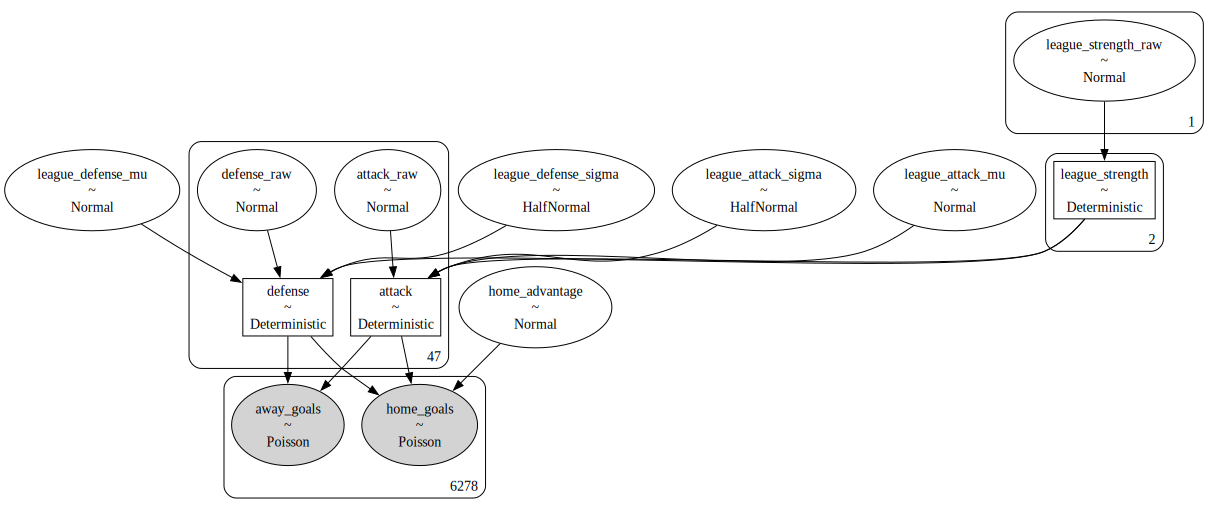

c:\Users\Owner\dev\team-model\.venv\Lib\site-packages\jax\_src\numpy\array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
c:\Users\Owner\dev\team-model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Owner\dev\team-model\.venv\Lib\site-packages\jax\_src\numpy\array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration optio

In [18]:
shot_data, match_stats = load_data(days_ago=365)

match_data = resimulate_matches_with_xg(match_stats, shot_data, n_simulations=5)

model_data = match_data[["home_team", "away_team", "home_goals", "away_goals", "match_date", "season", "division"]]
current_teams = model_data[model_data["season"] == 2024]["home_team"].unique()
team_leagues = dict(zip(model_data["home_team"], model_data["division"]))

model, team_indices, league_indices = build_bayesian_model(
    home_teams=model_data['home_team'],
    away_teams=model_data['away_team'],
    home_goals=np.array(model_data['home_goals']),
    away_goals=np.array(model_data['away_goals']),
    dates=model_data["match_date"],
    leagues=model_data["division"])

trace = sample_model(model, draws=1000, tune=1000, chains=4)

In [19]:
# Create a dictionary mapping each team to its league based on the most recent season
latest_season = model_data["season"].max()
previous_season = latest_season - 1

# Combine current and previous season data
combined_df = pd.concat([model_data[model_data["season"] == latest_season], model_data[model_data["season"] == previous_season]])

# Create a dictionary mapping each team to its league
team_leagues = dict(zip(combined_df["home_team"], combined_df["division"]))

# Get results
team_strengths, home_advantage = get_hierarchical_team_strengths(
    trace=trace,
    team_indices=team_indices,
    league_indices=league_indices,
    team_leagues=team_leagues,
    current_teams=current_teams
)

# Analyze league strengths
league_analysis = analyze_league_strengths(
    trace=trace,
    league_indices=league_indices,
    team_indices=team_indices,
    team_leagues=team_leagues
)

# Print results
print("\nTeam Strengths:")
print(team_strengths)
print(home_advantage)

print("\nLeague Analysis:")
print(league_analysis)


Team Strengths:
               team            league  attack_strength  defense_strength  \
21        Liverpool    Premier League            0.848            -0.041   
23  Manchester City    Premier League            0.810            -0.265   
10          Chelsea    Premier League            0.807            -0.527   
27    Newcastle Utd    Premier League            0.681            -0.339   
0           Arsenal    Premier League            0.576             0.025   
4       Bournemouth    Premier League            0.611            -0.449   
42        Tottenham    Premier League            0.647            -0.655   
12   Crystal Palace    Premier League            0.554            -0.280   
29  Nott'ham Forest    Premier League            0.419            -0.306   
5         Brentford    Premier League            0.488            -0.573   
1       Aston Villa    Premier League            0.439            -0.522   
15           Fulham    Premier League            0.418            -0.46